In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

from clusterless import preprocess
from clusterless import decoder
from clusterless import viz

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [3]:
rois = [roi.lower() for roi in ['PO', 'LP', 'DG', 'CA1', 'VIS']]

In [4]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, _, wheel_speed, _, _, _ = preprocess.preprocess_dynamic_behaviors(behave_dict)

decode all regions

In [51]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]
spike_channels = unsorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

kilosort_thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=False
)
print(f'kilosort thresholded neural data shape: {kilosort_thresholded_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
sorted neural data shape: (265, 514, 30)
kilosort thresholded neural data shape: (265, 380, 30)
good sorted neural data shape: (265, 83, 30)


In [52]:
windowed_good_sorted_neural_data, half_window_size, n_windows = decoder.sliding_window(
    good_sorted_neural_data, 
    n_trials,
    window_size = 7
)

In [53]:
windowed_sorted_neural_data, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    n_trials,
    window_size = 7
)

In [54]:
windowed_kilosort_thresholded_neural_data, half_window_size, n_windows = decoder.sliding_window(
    kilosort_thresholded_neural_data, 
    n_trials,
    window_size = 7
)

In [55]:
windowed_wheel_speed = wheel_speed[:,half_window_size:n_windows].reshape(-1,1)
windowed_motion_energy = motion_energy[:,half_window_size:n_windows].reshape(-1,1)

dynamic_behaviors = {
    'motion energy': windowed_motion_energy,
    'wheel speed': windowed_wheel_speed
}

In [ ]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_sorted_neural_data,
    windowed_motion_energy,
    n_trials,
    'motion energy'
)

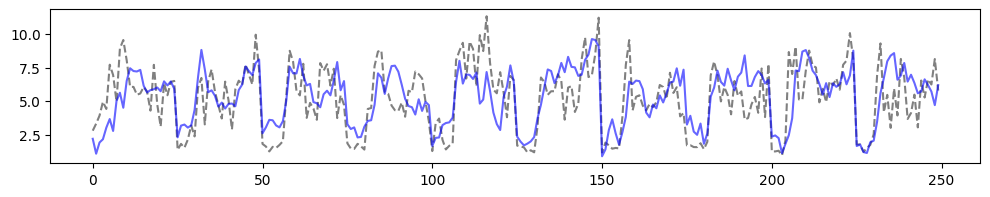

In [11]:
plt.figure(figsize=(12, 2))
plt.plot(np.hstack([cv_obs[0][i] for i in range(0, 50, 5)]), c='gray', linestyle='dashed', label='observed');
plt.plot(np.hstack([cv_preds[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), c='blue', alpha=.6, label='predicted');

In [ ]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_sorted_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

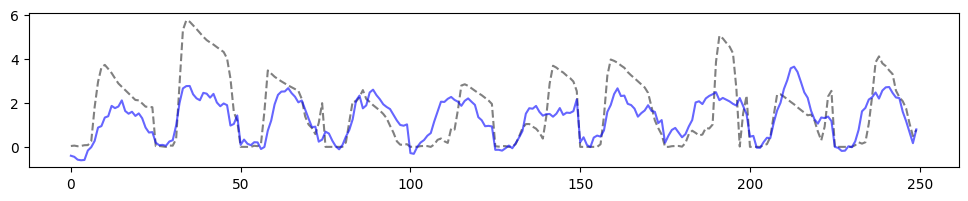

In [13]:
plt.figure(figsize=(12, 2))
plt.plot(np.hstack([cv_obs[0][i] for i in range(0, 50, 5)]), c='gray', linestyle='dashed', label='observed');
plt.plot(np.hstack([cv_preds[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), c='blue', alpha=.6, label='predicted');

In [56]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=False
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
thresholded neural data shape: (265, 384, 30)


In [57]:
windowed_thresholded_neural_data, half_window_size, n_windows = decoder.sliding_window(
    thresholded_neural_data, 
    n_trials,
    window_size = 7
)

In [ ]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_thresholded_neural_data,
    windowed_motion_energy,
    n_trials,
    'motion energy'
)

In [ ]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_thresholded_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

In [60]:
scales=(1, 1, 50)
log_c=5
x, z, maxptp = spike_features.T
spike_features = np.c_[x * scales[0], z * scales[1], np.log(log_c + maxptp) * scales[2]]

In [61]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/post_split_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = []
spike_probs = []
offset = 100_000
for i in range(8):
    print(f'loading batch {i+1} ...')
    spike_labels.extend(loaded_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(loaded_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=False
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

loading batch 1 ...
loading batch 2 ...
loading batch 3 ...
loading batch 4 ...
loading batch 5 ...
loading batch 6 ...
loading batch 7 ...
loading batch 8 ...
clusterless neural data shape: (265, 474, 30)


In [62]:
windowed_clusterless_neural_data, half_window_size, n_windows = decoder.sliding_window(
    clusterless_neural_data, 
    n_trials,
    window_size = 7
)

In [ ]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_motion_energy,
    n_trials,
    'motion energy'
)

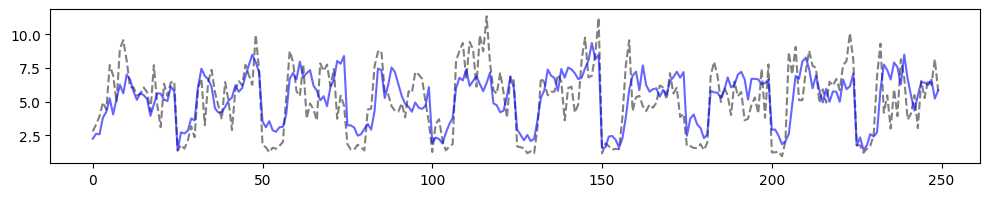

In [34]:
plt.figure(figsize=(12, 2))
plt.plot(np.hstack([cv_obs[0][i] for i in range(0, 50, 5)]), c='gray', linestyle='dashed', label='observed');
plt.plot(np.hstack([cv_preds[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), c='blue', alpha=.6, label='predicted');

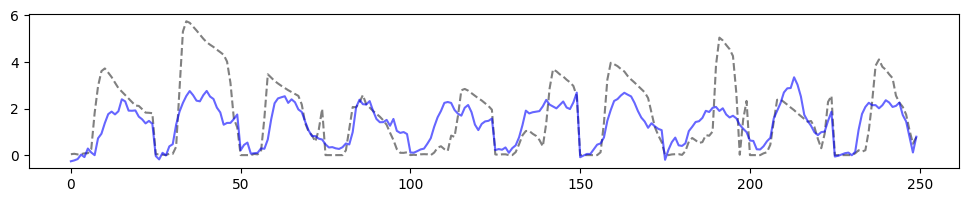

In [32]:
plt.figure(figsize=(12, 2))
plt.plot(np.hstack([cv_obs[0][i] for i in range(0, 50, 5)]), c='gray', linestyle='dashed', label='observed');
plt.plot(np.hstack([cv_preds[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), c='blue', alpha=.6, label='predicted');

In [ ]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

In [63]:
neural_data_dict = {
    'good units': windowed_good_sorted_neural_data,
    'sorted': windowed_sorted_neural_data,
    'kilosort thresholded': windowed_kilosort_thresholded_neural_data,
    'thresholded': windowed_thresholded_neural_data,
    'clusterless': windowed_clusterless_neural_data
} 

all_n_units_dict = {
        'good units': good_sorted_neural_data.shape[1],
        'sorted': sorted_neural_data.shape[1],
        'kilosort thresholded': kilosort_thresholded_neural_data.shape[1],
        'thresholded': thresholded_neural_data.shape[1],
        'clusterless': clusterless_neural_data.shape[1]
}

In [64]:
all_decode_results = {'motion energy': dict(), 'wheel speed': dict()}

for behave_type in all_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decoder.cv_decode_dynamic(
            neural_data_dict[data_type], 
            dynamic_behaviors[behave_type], 
            n_trials,
            behave_type=behave_type, 
            n_folds=5, 
            seed=seed
        )
        all_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{save_path}/dynamic_behaviors/all_decode_results.npy', all_decode_results)
# np.save(f'{save_path}/static_behaviors/all_n_units_dict.npy', all_n_units_dict)

good units:
motion energy fold 1 test r2: 0.390 rmse: 4.840
motion energy fold 2 test r2: 0.404 rmse: 4.663
motion energy fold 3 test r2: 0.483 rmse: 4.232
motion energy fold 4 test r2: 0.482 rmse: 4.427
motion energy fold 5 test r2: 0.443 rmse: 4.742
motion energy mean of 5-fold cv r2: 0.440 rmse: 4.581
motion energy sd of 5-fold cv r2: 0.039 rmse: 0.221
sorted:
motion energy fold 1 test r2: 0.461 rmse: 4.274
motion energy fold 2 test r2: 0.488 rmse: 4.003
motion energy fold 3 test r2: 0.551 rmse: 3.674
motion energy fold 4 test r2: 0.540 rmse: 3.931
motion energy fold 5 test r2: 0.522 rmse: 4.073
motion energy mean of 5-fold cv r2: 0.512 rmse: 3.991
motion energy sd of 5-fold cv r2: 0.033 rmse: 0.196
kilosort thresholded:
motion energy fold 1 test r2: 0.445 rmse: 4.406
motion energy fold 2 test r2: 0.489 rmse: 3.999
motion energy fold 3 test r2: 0.546 rmse: 3.716
motion energy fold 4 test r2: 0.529 rmse: 4.022
motion energy fold 5 test r2: 0.504 rmse: 4.224
motion energy mean of 5-fo

decode brain regions

In [113]:
roi = rois[4]
print(roi)

vis


In [114]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]
spike_channels = unsorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

kilosort_thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=True
)
print(f'kilosort thresholded neural data shape: {kilosort_thresholded_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
found 29 neurons in region vis ...
found 28 channels in region vis ...
sorted neural data shape: (265, 29, 30)
kilosort thresholded neural data shape: (265, 15, 30)
good sorted neural data shape: (265, 6, 30)


In [115]:
windowed_good_sorted_neural_data, half_window_size, n_windows = decoder.sliding_window(
    good_sorted_neural_data, 
    n_trials,
    window_size = 7
)

In [116]:
windowed_sorted_neural_data, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    n_trials,
    window_size = 7
)

In [117]:
windowed_kilosort_thresholded_neural_data, half_window_size, n_windows = decoder.sliding_window(
    kilosort_thresholded_neural_data, 
    n_trials,
    window_size = 7
)

In [118]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=False,
    triage=False
)

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=True
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
found 29 neurons in region vis ...
found 28 channels in region vis ...
thresholded neural data shape: (265, 27, 30)


In [119]:
windowed_thresholded_neural_data, half_window_size, n_windows = decoder.sliding_window(
    thresholded_neural_data, 
    n_trials,
    window_size = 7
)

In [120]:
scales=(1, 1, 50)
log_c=5
x, z, maxptp = spike_features.T
spike_features = np.c_[x * scales[0], z * scales[1], np.log(log_c + maxptp) * scales[2]]

In [121]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/post_split_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=True
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 32, 30)


In [122]:
windowed_clusterless_neural_data, half_window_size, n_windows = decoder.sliding_window(
    clusterless_neural_data, 
    n_trials,
    window_size = 7
)

In [123]:
neural_data_dict = {
        'good units': windowed_good_sorted_neural_data,
        'sorted': windowed_sorted_neural_data,
        'kilosort thresholded': windowed_kilosort_thresholded_neural_data,
        'thresholded': windowed_thresholded_neural_data,
        'clusterless': windowed_clusterless_neural_data
} 

regional_n_units_dict = {
        'good units': good_sorted_neural_data.shape[1],
        'sorted': sorted_neural_data.shape[1],
        'kilosort thresholded': kilosort_thresholded_neural_data.shape[1],
        'thresholded': thresholded_neural_data.shape[1],
        'clusterless': clusterless_neural_data.shape[1]
}

In [124]:
regional_decode_results = {'motion energy': dict(), 'wheel speed': dict()}

for behave_type in regional_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decoder.cv_decode_dynamic(
            neural_data_dict[data_type], 
            dynamic_behaviors[behave_type], 
            n_trials,
            behave_type=behave_type, 
            n_folds=5,
            seed=seed
        )
        regional_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{save_path}/dynamic_behaviors/{roi}_decode_results.npy', regional_decode_results)
# np.save(f'{save_path}/static_behaviors/{roi}_n_units_dict.npy', regional_n_units_dict)

good units:
motion energy fold 1 test r2: 0.113 rmse: 7.041
motion energy fold 2 test r2: 0.119 rmse: 6.885
motion energy fold 3 test r2: 0.127 rmse: 7.147
motion energy fold 4 test r2: 0.129 rmse: 7.448
motion energy fold 5 test r2: 0.127 rmse: 7.429
motion energy mean of 5-fold cv r2: 0.123 rmse: 7.190
motion energy sd of 5-fold cv r2: 0.006 rmse: 0.219
sorted:
motion energy fold 1 test r2: 0.168 rmse: 6.600
motion energy fold 2 test r2: 0.210 rmse: 6.181
motion energy fold 3 test r2: 0.214 rmse: 6.436
motion energy fold 4 test r2: 0.231 rmse: 6.576
motion energy fold 5 test r2: 0.190 rmse: 6.895
motion energy mean of 5-fold cv r2: 0.202 rmse: 6.538
motion energy sd of 5-fold cv r2: 0.022 rmse: 0.233
kilosort thresholded:
motion energy fold 1 test r2: 0.151 rmse: 6.738
motion energy fold 2 test r2: 0.197 rmse: 6.277
motion energy fold 3 test r2: 0.235 rmse: 6.263
motion energy fold 4 test r2: 0.208 rmse: 6.769
motion energy fold 5 test r2: 0.202 rmse: 6.791
motion energy mean of 5-fo

plotting

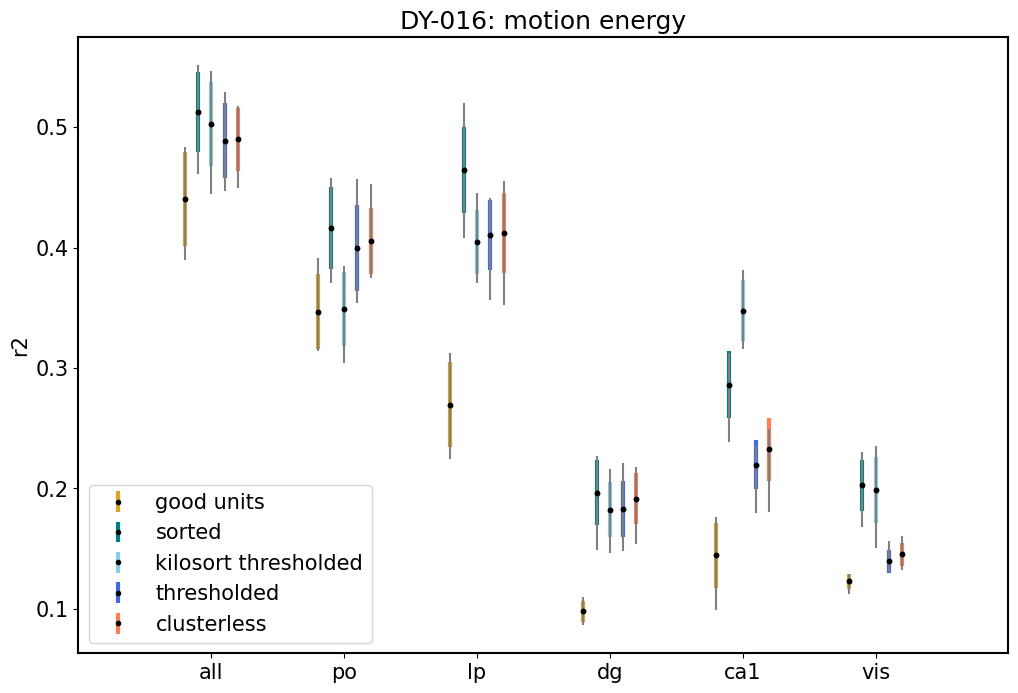

In [125]:
viz.plot_compare_decoder_barplots(
    save_path + '/dynamic_behaviors',
    'motion energy', 
    'r2', 
    rois, 
    n_folds=5, 
    add_smooth=False, 
    figure_size=(12,8), 
    font_size=15, 
    title='DY-016: motion energy',
    save_fig=False,
    fig_path='../saved_figs/danlab/Subjects/DY_016',
)

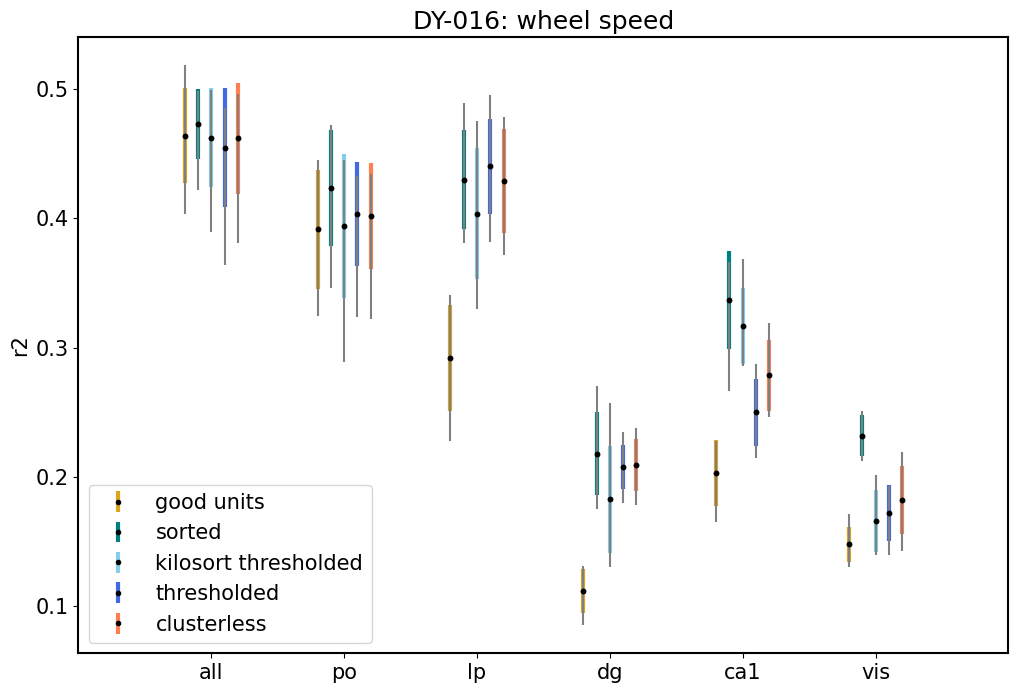

In [126]:
viz.plot_compare_decoder_barplots(
    save_path + '/dynamic_behaviors',
    'wheel speed', 
    'r2', 
    rois, 
    n_folds=5, 
    add_smooth=False, 
    figure_size=(12,8), 
    font_size=15, 
    title='DY-016: wheel speed',
    save_fig=False,
    fig_path='../saved_figs/danlab/Subjects/DY_016',
)